In [1]:
0

0

In [1]:
cd ..

/playpen-raid1/tgreer/FeatureMapICON


In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import subprocess
import footsteps
import os
import glob
from PIL import Image
import numpy as np
import tqdm
import torch

def DavisEval(model, name):
    davis_path = "data_storage/DAVIS/"
    output_path = footsteps.output_dir + name + "/"
    
    os.mkdir(output_path)
    with open(davis_path + "/ImageSets/2017/val.txt", "r") as f:
        sequences = f.readlines()
    for sequence in tqdm.tqdm(sequences):
        sequence = sequence[:-1]  # strip newline
        sequence_out_path = output_path + sequence + "/"
        sequence_img_path = davis_path + "JPEGImages/480p/" + sequence + "/"
        with open(davis_path + "Annotations/480p/" + sequence + "/00000.png", "rb") as handle:
          first_annotation = np.array(
            Image.open(handle)
          )

        os.mkdir(output_path + sequence)
        with open(sequence_img_path + "00000.jpg", "rb") as handle:
          first_image = np.array(Image.open(handle))

        prev_image = first_image
        prev_annotation = first_annotation

        for i in range(1, len(os.listdir(sequence_img_path))):
            
            with open(sequence_img_path + f"{i:05}.jpg", "rb") as handle:
              curr_image = np.array(Image.open(handle))
            annotation = model(
                first_image, first_annotation, prev_image, prev_annotation, curr_image
            )
            Image.fromarray(annotation).save(sequence_out_path + f"{i:05}.png")

            prev_image = curr_image
            prev_annoration = first_annotation
    
    subprocess.run(
        [
            "python",
            "davis2017-evaluation/evaluation_method.py",
            "--davis_path",
            "data_storage/DAVIS",
            "--results_path",
            output_path,
            "--task",
            "semi-supervised",
        ]
    )


Input name of experiment:
ghjkghjk


In [3]:
import fmapicon.training

In [4]:

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
l = []

def execute_model(A, B, model):
    N = A.shape[0]
    SIDE_LENGTH = A.shape[2]
    
    
    A = torch.tensor(A).cuda().permute(0, 3, 1, 2).float()
    B = torch.tensor(B).cuda().permute(0, 3, 1, 2).float()
    feats_a = model(A)
    feats_b = model(B)

    # to (N, C, H*W)
    feats_a = feats_a.reshape(feats_a.shape[0],
        feats_a.shape[1], feats_a.shape[2] * feats_a.shape[3])
    feats_b = feats_b.reshape(feats_b.shape[0],
        feats_b.shape[1], feats_b.shape[2] * feats_b.shape[3])

    feats_a = feats_a.permute(0, 2, 1)

    #return feats_a
    cc = torch.bmm(feats_a, feats_b)

    cc = nn.functional.softmax(cc, dim=-1)


    cc = cc.reshape([N] + [SIDE_LENGTH] * 4)
    #cc = np.array(cc.cpu().detach())
    
    cc2 = cc.reshape([N, SIDE_LENGTH, SIDE_LENGTH, SIDE_LENGTH**2])
    
    index_grid = torch.argmax(cc2, axis=-1).cpu().detach()[:, :, :, None].numpy()
    
    


    grid = np.concatenate([index_grid % SIDE_LENGTH, index_grid / SIDE_LENGTH], axis=-1)
    
    return cc, grid

class FMAPICON_model:
    def __init__(self, weights_path):
        self.inner_model = fmapicon.training.tallerUNet2().cuda()
        self.inner_model.load_state_dict(torch.load(weights_path))
        
    def __call__(self, initial_frame, initial_mask, prev_frame, prev_mask, current_frame):
        crop = (initial_frame.shape[1] - initial_frame.shape[0]) // 2
        B = initial_frame[None, ::4, crop:-crop:4] / 255.   
        A = current_frame[None, ::4, crop:-crop:4] / 255.
        
        cc, grid = execute_model(A, B, self.inner_model)
        m = initial_mask[2::4, 2+crop:-crop:4]

        shitty_res = m[grid[0, :, :, 1].astype(int), grid[0, :, :, 0].astype(int)]

        up_res = np.repeat(np.repeat(shitty_res, 4, axis=0),4, axis=1)
        
        out_mask = initial_mask.copy()
        
        out_mask[:, crop:-crop] = up_res
        """
        plt.imshow(A[0])
        plt.show()
        plt.imshow(B[0])
        plt.show()
        plt.imshow(shitty_res)
        plt.show()
        plt.imshow(out_mask)
        plt.show()
        #l.append(up_res)
        
        plt.imshow(grid[0, :, :, 0])
        plt.show()
        
        l.append((cc, A, B, initial_mask))
        """
        

        return out_mask

#DavisEval(FMAPICON_model("tensorflow_/results/log_probability_2/epoch50/model_weights.tf"), "FMAPICON")
#DavisEval(FMAPICON_model("tensorflow_/results/clip.6_11/epoch51/model_weights.tf"), "FMAPICON")

In [5]:
DavisEval(FMAPICON_model(f"results/hjkl/network00002.trch"), f"mannequin")

  0%|          | 0/30 [00:00<?, ?it/s]

Evaluating sequences for the semi-supervised task...


100%|██████████| 30/30 [01:45<00:00,  3.52s/it]


Global results saved in results/ghjkghjk/mannequin/global_results-val.csv
Per-sequence results saved in results/ghjkghjk/mannequin/per-sequence_results-val.csv
--------------------------- Global results for val ---------------------------
 J&F-Mean   J-Mean  J-Recall  J-Decay   F-Mean  F-Recall  F-Decay
 0.272081 0.232134  0.130115 0.298259 0.312028  0.180337 0.307008

---------- Per sequence results for val ----------
            Sequence   J-Mean   F-Mean
      bike-packing_1 0.282649 0.652331
      bike-packing_2 0.434379 0.550360
         blackswan_1 0.535287 0.337409
         bmx-trees_1 0.045233 0.198422
         bmx-trees_2 0.123344 0.154736
        breakdance_1 0.321054 0.352677
             camel_1 0.424920 0.338467
    car-roundabout_1 0.413661 0.244855
        car-shadow_1 0.377656 0.263880
              cows_1 0.485675 0.359569
       dance-twirl_1 0.267650 0.449957
               dog_1 0.404783 0.301146
         dogs-jump_1 0.114284 0.212880
         dogs-jump_2 0.113976 0

In [7]:
DavisEval(FMAPICON_model(f"results/kinetics_train/network00005.trch"), f"kinetics")

100%|███████████████████████████████████████████| 30/30 [01:44<00:00,  3.47s/it]


Evaluating sequences for the semi-supervised task...


 97%|█████████▋| 29/30 [01:24<00:03,  3.21s/it]

Global results saved in results/mannequin_kinetics_comparison/kinetics/global_results-val.csv
Per-sequence results saved in results/mannequin_kinetics_comparison/kinetics/per-sequence_results-val.csv
--------------------------- Global results for val ---------------------------
 J&F-Mean   J-Mean  J-Recall  J-Decay   F-Mean  F-Recall  F-Decay
 0.241887 0.205535  0.099022 0.253584 0.278239  0.118197 0.277442

---------- Per sequence results for val ----------
            Sequence   J-Mean   F-Mean
      bike-packing_1 0.250795 0.603043
      bike-packing_2 0.391641 0.506675
         blackswan_1 0.482037 0.347695
         bmx-trees_1 0.035233 0.172760
         bmx-trees_2 0.102195 0.146547
        breakdance_1 0.255116 0.314187
             camel_1 0.392950 0.355864
    car-roundabout_1 0.409845 0.263112
        car-shadow_1 0.303740 0.204083
              cows_1 0.393366 0.311156
       dance-twirl_1 0.232540 0.404738
               dog_1 0.371232 0.293075
         dogs-jump_1 0.107544 

100%|██████████| 30/30 [01:30<00:00,  3.02s/it]


In [7]:
model = FMAPICON_model("pytorch/results/no_crop_no_pretrain/network00019.trch").inner_model

In [8]:
cc,A,B,m=l[0]

In [9]:
cc, grid = execute_model(A, B, model, N=1)

In [10]:
import pytorch.training
feats_A = pytorch.training.warping(model, torch.tensor(A).cuda().permute(0, 3, 1, 2).float()).detach().cpu().numpy()
feats_B = model(torch.tensor(B).cuda().permute(0, 3, 1, 2).float()).detach().cpu().numpy()

/playpen-raid1/tgreer/anaconda3/envs/gpu3torchext/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/playpen-raid1/tgreer/anaconda3/envs/gpu3torchext/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


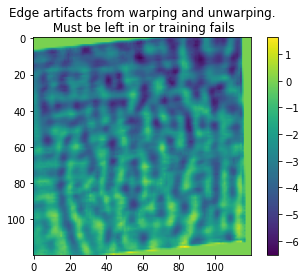

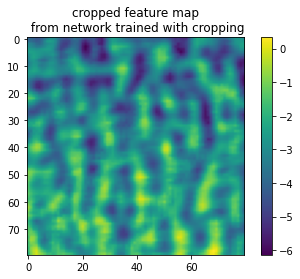

In [13]:
plt.figure()
plt.imshow(feats_A[0, 0])
plt.title("Edge artifacts from warping and unwarping.\n Must be left in or training fails")
plt.colorbar()
plt.figure()
plt.title("cropped feature map\n from network trained with cropping")
plt.imshow(feats_A[0, 0, 20:-20, 20:-20])
plt.colorbar()
plt.show()

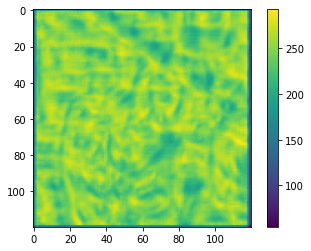

In [48]:
plt.imshow(np.sum(feats_A[0 , :32]**2, axis=0))
plt.colorbar()

In [ ]:
plt.imshow(feats_A[0 , 18])
plt.colorbar()
plt.show()
plt.imshow(feats_B[0 , 18])
plt.colorbar()

In [ ]:
#plt.imshow(grid[0, :, :, 0].transpose())
#plt.show()
plt.imshow(A[0])
plt.show()
plt.imshow(B[0])
plt.show()

In [ ]:
shitty_res = m[grid[0, :, :, 1].astype(int) + 15, grid[0, :, :, 0].astype(int) + 15].transpose()

up_res = np.repeat(np.repeat(shitty_res, 4, axis=0),4, axis=1)

In [8]:
import torch
torch.__version__

'1.8.0'

In [ ]:
plt.imshow(m[15:-15, 15:-15])

In [ ]:
len(l)

In [ ]:
plt.imshow(cc[0, 100, 110])
plt.colorbar()

In [30]:
import scipy
x = np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]])
print(scipy.ndimage.measurements.center_of_mass(x.transpose()))
z = np.argmax(x)
(z % 3, z // 3)

(1.0, 0.0)


(1, 0)

In [ ]:
DavisEval(FMAPICON_model("pytorch/results/deeeep_warp/network00006.trch"), "FMAPICON3")